In [1]:
import tensorflow as tf
import keras
from keras_vggface.vggface import VGGFace
from matplotlib import pyplot as plt
import datetime
import cv2
import PIL
from tensorflow.keras.models import load_model
import numpy as np

#### if encounter error "ModuleNotFoundError: No module named 'keras.engine.topology'"

locate keras_vggface/models.py for example ../../../miniconda3/envs/ML/lib/python3.9/site-packages/keras_vggface/models.py

changing the import from

from keras.engine.topology import get_source_inputs

to

from keras.utils.layer_utils import get_source_inputs

#### GPU Check

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
train_dataset = keras.utils.image_dataset_from_directory('datasets_VGG',
                                                         validation_split = 0.1,
                                                         subset="training",
                                                         seed = 69420,
                                                         batch_size=16,
                                                         image_size=(224,224))

Found 570 files belonging to 2 classes.
Using 513 files for training.


In [5]:
valid_dataset = keras.utils.image_dataset_from_directory('datasets_VGG',
                                                         validation_split = 0.1,
                                                         subset="validation",
                                                         seed = 69420,
                                                         batch_size=16,
                                                         image_size=(224,224))

Found 570 files belonging to 2 classes.
Using 57 files for validation.


In [6]:
valid_dataset_unbatch = valid_dataset.unbatch()
valid_imgs = list(valid_dataset_unbatch.map(lambda x, y: x))
valid_labels= list(valid_dataset_unbatch.map(lambda x, y: y))

In [7]:
data_aug = keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomBrightness(0.1),
    tf.keras.layers.RandomContrast(0.1)
])

In [8]:
vggface_resnet_base = VGGFace(model='resnet50')

In [9]:
print('Inputs: %s' % vggface_resnet_base.inputs)
print('Outputs: %s' % vggface_resnet_base.outputs)

Inputs: [<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_1')>]
Outputs: [<KerasTensor: shape=(None, 8631) dtype=float32 (created by layer 'classifier')>]


In [10]:
from keras.layers import Flatten, Dense, Input

In [11]:
vggface_resnet_base.trainable = False
last_layer = vggface_resnet_base.get_layer('avg_pool').output

inputs = tf.keras.Input(shape=(224,224,3))

x = data_aug(inputs)
x = vggface_resnet_base(x)
x = Flatten(name='flatten')(x)

out = Dense(4, name='classifier')(x)
custom_model = keras.Model(inputs, out)

In [12]:
base_lr = 0.001

custom_model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=base_lr),
                     loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                     metrics=['accuracy'])

In [13]:
custom_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 vggface_resnet50 (Functiona  (None, 8631)             41246071  
 l)                                                              
                                                                 
 flatten (Flatten)           (None, 8631)              0         
                                                                 
 classifier (Dense)          (None, 4)                 34528     
                                                                 
Total params: 41,280,599
Trainable params: 34,528
Non-trainable params: 41,246,071
____________________________________________

In [14]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                                  patience=5)

In [15]:
his = custom_model.fit(train_dataset, validation_data=valid_dataset, 
                       epochs=300, callbacks=[early_stopping])

Epoch 1/300
33/33 [==============================] - 38s 970ms/step - loss: 1.3582 - accuracy: 0.6998 - val_loss: 1.3235 - val_accuracy: 1.0000
Epoch 2/300
33/33 [==============================] - 24s 732ms/step - loss: 1.2999 - accuracy: 0.8655 - val_loss: 1.2636 - val_accuracy: 1.0000
Epoch 3/300
33/33 [==============================] - 27s 820ms/step - loss: 1.2472 - accuracy: 0.8421 - val_loss: 1.2093 - val_accuracy: 1.0000
Epoch 4/300
33/33 [==============================] - 23s 692ms/step - loss: 1.1978 - accuracy: 0.8402 - val_loss: 1.1572 - val_accuracy: 1.0000
Epoch 5/300
33/33 [==============================] - 23s 695ms/step - loss: 1.1520 - accuracy: 0.8635 - val_loss: 1.1081 - val_accuracy: 1.0000
Epoch 6/300
33/33 [==============================] - 24s 711ms/step - loss: 1.1077 - accuracy: 0.8694 - val_loss: 1.0616 - val_accuracy: 1.0000
Epoch 7/300
33/33 [==============================] - 30s 925ms/step - loss: 1.0697 - accuracy: 0.8577 - val_loss: 1.0179 - val_accuracy:

Text(0, 0.5, 'Loss')

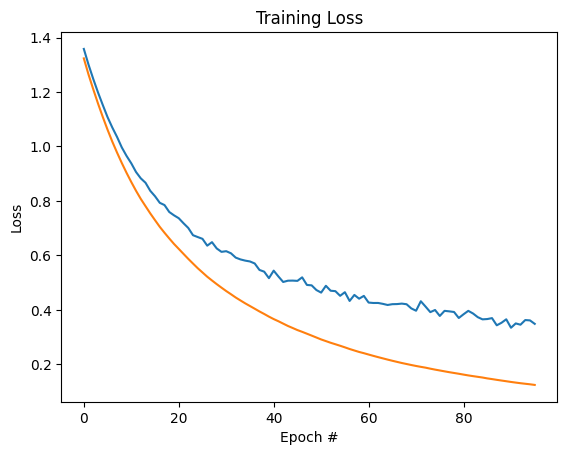

In [16]:
plt.figure()
plt.plot(his.history['loss'])
plt.plot(his.history['val_loss'])
plt.title('Training Loss')
plt.xlabel('Epoch #')
plt.ylabel('Loss')

Text(0, 0.5, 'Accuracy')

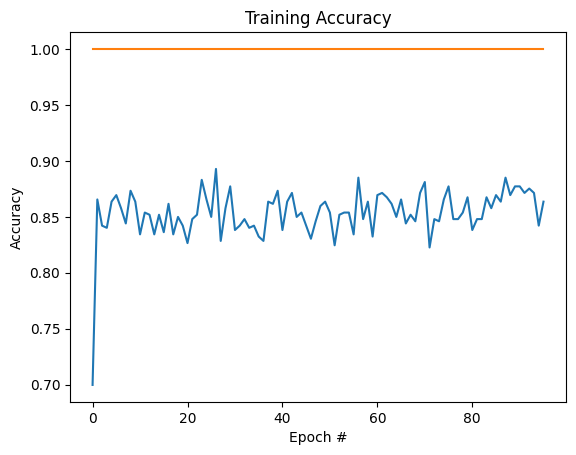

In [17]:
plt.figure()
plt.plot(his.history['accuracy'])
plt.plot(his.history['val_accuracy'])
plt.title('Training Accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Accuracy')

In [18]:
prob_model = keras.Sequential([custom_model,
                               tf.keras.layers.Softmax()
                               ])

In [22]:
time_stamp = datetime.datetime.now()
time_stamp.strftime("%d_%b_%y_%H_%M_%S")
prob_model.save(f"model/model_{time_stamp.date()}_{time_stamp.timestamp()}.tf")

INFO:tensorflow:Assets written to: model/model_2025-09-03_1756862707.101024.tf\assets


INFO:tensorflow:Assets written to: model/model_2025-09-03_1756862707.101024.tf\assets
